## Prerequisites:

Run the below cell to install the dependencies for this project and mount the drive:

In [ ]:
#@title Installing packages
%%capture
!pip install numpy pandas matplotlib emoji==1.6.3 torch lrcurve gradio wandb fsspec dask[bag]

In [ ]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive', force_remount=False)

#@markdown Specify the full "DLE-Projects" folder in your Google Drive.
#@markdown You can find this by navigating in the folder icon tab on the left.
directory = '/content/drive/MyDrive/DLE-Projects/' #@param {type:"string"}

sys.path.append(directory)
sys.path.append(os.path.join(directory, 'utils'))
os.chdir(os.path.join(directory, 'Week3'))
%matplotlib inline

# This is the directory that local changes get saved to.
# Change this if you'd like to save them somewhere else!
os.chdir('/content/drive/MyDrive/Colab Notebooks/')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
#@title Import packages
%%capture
%load_ext autoreload
%autoreload 2
import gradio as gr
import torch
torch.backends.cudnn.benchmark = True
import io
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import emoji
import wandb
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score, classification_report
import imageio
import torchvision

import constants as const
from utils import *
from quickdraw import *
from assignment_helpers import *

from torchvision import transforms, utils
from PIL import Image
import random

os.environ['WANDB_START_METHOD']="thread"
torch.manual_seed(0)

# Welcome to Week 3!

This week, we'll be using our knowledge of building and training neural networks toward computer vision!

## Overview of Week 3

1. Convolutions
  - First, you will be exploring the convolutional operation in PyTorch. Here, you'll get hands-on intuition for what happens under the hood of a Convolutional layer.
2. Convolutional neural networks
  - Building upon our model training and evaluation experience from last week, you will write, train, and evaluate your own convolutional neural network and compare its performance to an MLP.
4. Experimenting with GANs
  - Finally, you will go beyond classification and train a GAN (generative adversarial network). Here, you will fine-tune a pre-trained GAN on face styles, and then apply this style filter to your own face!


# Part 1: CNNs

## The Convolutional Layer

Convolutional Neural Networks (CNNs) the model of choice for most computer vision tasks, and they are behind the massive advances made in AI over the last 10 years. At the very core of CNNs are the convolutional layer. When you think of CNNs, you can think of many stacked convolutional layers.

<img src="https://drive.google.com/uc?id=1iDkeAz-6Z0sysulWA3wvNid3AO0yayJR" width="600">

In this first part, we will be probing into the convolutional layer. The goal here is to develop a deeper intuition for how and why they work!

To implement a convolutional layer in PyTorch, just use ```nn.Conv2d()```.

Read the documentation for this layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and implement a 2D convolutional layer with 1 input channel, 3 output channel, and a 5x5 kernel:




In [ ]:
# TODO: Implement a 2D convolutional layer with 1 input channel, 3 output channel, and a 5x5 kernel

conv_layer = nn.Conv2d(1, 3, (5, 5))

check_answer(type(conv_layer)==nn.modules.conv.Conv2d and  conv_layer.in_channels==1 and conv_layer.out_channels==3 and conv_layer.kernel_size==(5, 5))

## Correct! 🎉

Let's investigate this layer!

First, we will look at the weights. In the cell below, compute and print the shape of ```conv_layer```'s weights.

In [ ]:
# TODO: Compute and print the shape of the weights of conv_layer

weights_shape = conv_layer.weight.shape

print(f'Shape of the weights of conv_layer; {weights_shape}')

check_answer(weights_shape==(3, 1, 5, 5))

Shape of the weights of conv_layer; torch.Size([3, 1, 5, 5])


## Correct! 🎉

In [ ]:
from IPython.display import display, Markdown
#@title Pop Quiz! { vertical-output: true, form-width: "500px" }
#@markdown
#@markdown #####  Without writing any code, what is the first dimension of the following layer's weights? (Or in Python, the 0th)
#@markdown ```nn.Conv2d(32, 64, 7)```

Answer =  64#@param {type:"integer"}

#@markdown (Run cell to submit.)

if Answer == 64:
  display(Markdown('''
  ### ***Correct! 🎉***
  There are four dimensions to the weights of a convolutional layer:

  The first dimension is the number of output channels, the second dimension is the number of input channels, and the last two dimensions are the kernel size.
  '''))
else:
  display(Markdown('### Answer is incorrect, try again!'))


  ### ***Correct! 🎉***
  There are four dimensions to the weights of a convolutional layer:
  
  The first dimension is the number of output channels, the second dimension is the number of input channels, and the last two dimensions are the kernel size. 
  

Next, let's feed data through this layer to see what it does to it.

Notice that we'll need to add a "channel" dimension to an image in order to feed it through the layer.

In the cell below, create a PyTorch tensor with dimensions (1, 64, 64) and print out the dimensions of the output from the layer.

In [ ]:
# TODO: Create input -- PyTorch tensor with dimension (1, 64, 64)
input_image = torch.Tensor(1, 64, 64)

# TODO: Feed it through conv_layer
conv_output = conv_layer(input_image)

# TODO: Print dimensions
print(conv_output.shape)

check_answer(conv_output.size()==torch.Size([3, 60, 60]))

torch.Size([3, 60, 60])


## Correct! 🎉

Notice that the shape of the image has changed!

It went from one "slice" of a 64x64 image to three "slices" of 60x60.

So what happened?

The convolutional operation cuts off part of the edges of the input image (this was covered in the lecture slides). Additionally, it creates three copies of the input image and performs separate convolutional operations on each of these copies according to different kernels (remember we had 3 5x5 kernels from the weights).

In [ ]:
from IPython.display import display, Markdown
#@title Pop Quiz! { vertical-output: true, form-width: "500px" }
#@markdown
#@markdown Without running the code below, what will the last line return (think about it)?

#@markdown ```input_x = torch.Tensor(64, 124, 124)```

#@markdown ```layer = nn.Conv2d(64, 128, 5)```

#@markdown ```print(layer(input_x).size())```

Answer = torch.Size([128, 120, 120]) #@param {type:"raw"}

#@markdown (Run cell to submit.)

if Answer == torch.Size([128, 120, 120]):
  display(Markdown('''
  ### ***Correct!*** 🎉
  The convolutional layer "shaves off" 4 pixels off each side of the input image.

  For an image with $n$ pixels on each side will have ($n-$ kernel_size $+1$) after passing through a convolutional layer.

  (One day, someone might ask you this in a job interview and you'll be happy to know this 😀)
  '''))
else:
  display(Markdown('### Answer is incorrect, try again!'))


  ### ***Correct!*** 🎉
  The convolutional layer "shaves off" 4 pixels off each side of the input image.

  For an image with $n$ pixels on each side will have ($n-$ kernel_size $+1$) after passing through a convolutional layer.
  
  (One day, someone might ask you this in a job interview and you'll be happy to know this 😀)
  

Next, let's see how the convolutional layers actually work! (It's kind of neat)

To do this, we will be manually specifying the weights of ```conv_layer```.

In the cell below, set the weights as the three matrices described and zero out the bias.

In [ ]:
''' TODO: First, create three PyTorch tensors:
1. A 5x5 tensor that contains 1 on the 3rd column and zeros elsewhere:
    0  0  1  0  0
    0  0  1  0  0
    0  0  1  0  0
    0  0  1  0  0
    0  0  1  0  0
2. A 5x5 tensor that contains 1 on the 3rd row and zeros elsewhere:
    0  0  0  0  0
    0  0  0  0  0
    1  1  1  1  1
    0  0  0  0  0
    0  0  0  0  0
3. A 5x5 tensor that has 1s on the diagonal and zeros elsewhere:
    1  0  0  0  0
    0  1  0  0  0
    0  0  1  0  0
    0  0  0  1  0
    0  0  0  0  1
'''


filter_1 = torch.zeros(1, 5, 5)
filter_1[:,:,2]=1

filter_2 = torch.zeros(1, 5, 5)
filter_2[:,2,:]=1

filter_3 = torch.zeros(1, 5, 5)
filter_3[0].fill_diagonal_(1)
# TODO: Next, using your PyTorch tensor manipulation prowess, find a way to set these three filters as the weights of conv_layer.

conv_layer.weight = torch.nn.Parameter(torch.stack((filter_1,filter_2,filter_3),axis=0))
# TODO: Finally, zero out the bias!

conv_layer.bias = nn.Parameter(torch.zeros((3,)))

In [ ]:
#@markdown ### Run this cell to check your answer!

check_answer(all(np.linalg.eig(conv_layer.weight[0][0].detach().numpy())[0]==[0., 0., 0., 0., 1.]) and \
             all(np.linalg.eig(conv_layer.weight[1][0].detach().numpy())[0] == [1., 0., 0., 0., 0.]) and \
             all(np.linalg.eig(conv_layer.weight[2][0].detach().numpy())[0] == [1., 1., 1., 1., 1.]))

## Correct! 🎉

Now that we've set up our own convolutional layer, let's see how it works!

Run the cell below.

In the sketchpad, draw any shape (start with a circle). This is just intuition building for you -- notice what parts of the shape are highlighted for each filter.

Remember, the first filter is a vertical line, the second is a horizontal line, and the third is a diagonal.

In [ ]:
'''
If you did the above correctly, then you should be able to just press run on the demo below!
'''

def get_filters(image):
    image = 1. - image / 255.
    pt_input = torch.Tensor(image).view(1, 1, image.shape[0], image.shape[1])
    conv_output = conv_layer(pt_input).detach().numpy()[0]
    num_filters = conv_output.shape[0]
    fig, axes = plt.subplots(1, num_filters)
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=0.5)

    for i in range(num_filters):
        ax = axes[i]
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.imshow(conv_output[i], cmap='seismic_r')
        ax.title.set_text(f'Convolution w/ \n filter {i+1}')

    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    return data


see_filters = gr.Interface(get_filters, inputs='sketchpad', outputs='image', live=True).launch(debug=True)

Hint: Set streaming=True for Sketchpad component to use live streaming.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 285, in run_predict
    fn_index, raw_input, username, session_state, iterators
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 982, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 825, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-19-95e1d58560a3>", line 6, in get_filters
    image = 1. - image /

Keyboard interruption in main thread... closing server.


Great! Hopefully, you will see that the reason why kernels work is because they highlight different features in the image, depending on what the values are!

**Bonus**

A few things to consider when trying to understand these plots:

1. See what happens when you draw something on the border. The output of the convolutional layer seems to get cut off! This is partially due to the fact that the image shrinks. In defining the Conv2d layer, there is a parameter called ```padding```. Setting ```padding='same'``` will add zeros to the input before passing it through. Add this parameter in and see if this helps when you are drawing things near the border!

2. You might notice that sometimes, horizontal lines will "active" under the filter with the vertical line. This is due to the thickness of the pen stroke in the sketchpad. Will doubling the thickness in the filter change this?

3. You don't/shouldn't spend too much time on this, but are there other types of filters you can think of that show up when used? Feel free to go back to the previous cells to change them around.

### Pooling layers

Pooling layers are commonly combined with convolutional layers to improve model efficiency and power. Let's gain some intuition on what's going on when we use a pooling layer.

PyTorch has two types of pooling layers: `MaxPool2d`, and `AvgPool2d`. Each takes a parameter, `kernel_size`, which determines by what factor to pool the image by.

**TODO**: Given the image in ```img```, visualize the images that are outputted by 1) average pooling, and 2) max pooling. For both, use a kernel size of 8.

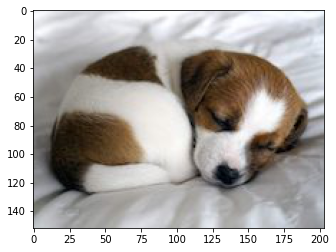

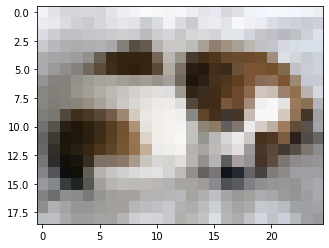

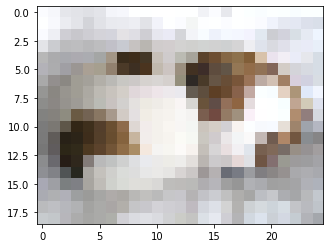

## Correct! 🎉

In [ ]:
# The image is loaded into img
img = torch.tensor(imageio.imread(os.path.join(directory, 'assets/puppy.jpeg'))).permute(2, 0, 1)/255.

plt.imshow(img.permute(1, 2, 0))
plt.show()
# Note: permute() moves the channel dimension to end.
# We do this to follow Matplotlib convention of "channels last", while PyTorch is "channels first"

# TODO: Create a nn.AvgPool2d(8) layer and apply it to the image.
avg_pool = nn.AvgPool2d(8)
avg_img = avg_pool(img)
# TODO: Visualize the image. You will have to use .permute() and .numpy() to plot it!
plt.imshow(avg_img.permute(1, 2, 0))
plt.show()

# TODO: Do the same with a nn.MaxPool2d(8) layer.
max_pool = nn.MaxPool2d(8)
max_img = max_pool(img)
plt.imshow(max_img.permute(1, 2, 0))
plt.show()

check_answer(round(np.linalg.norm(avg_img))==25 and round(np.linalg.norm(max_img))==29)

As you'll notice, both layers accomplish similar tasks -- reducing the dimension of the image while preserving the general gist of it!

Can you think of some differences in the image and how taking average would be different than taking a max?

## 2. Convolutional Neural networks

Our goal this week is to *improve* the model that you trained last week with convolutional layers.

Notice that last week, all of our neural network training was performed on the CPU. This week, as we scale up the size of our models, we will harness the power of GPUs!

PyTorch makes this simple to do. In order to train on GPUs, PyTorch needs to first know the name of the GPU device we hope to train on. This is done by:

    device = torch.device('cuda')

*Cuda* is the name of the library that performs neural network operations on the GPU. Now, we use the `device` variable to send *1) data* and *2) weights* to the GPU. We can do this with the `.to(device)` call.

For instance, to send a PyTorch Tensor `x` to GPU, do:

    x.to(device)


**TODO**: Copy/paste your QuickDraw `Dataset` class from last week in the cell below. Then, send the `X` and `y` variables in the `__getitem__` method of your `Dataset` class to GPU. Then, instantiate the `train_dataloader`, `val_dataloader`, and `test_dataloader` variables like you had last week.

In [ ]:
data_dir = './data'
labels = list(const.DOODLE_TO_EMOJI_MAP.keys())
device = torch.device('cuda')


... # TODO: Copy your Dataset class here and modify the __getitem__() function
class QuickDrawDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir=None, class_names=None, device=None):
        super().__init__()

        # TODO: Initialize data_dir, class_names, and num_classes instance variables
        self.data_dir = data_dir
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.max_items_per_class = 20000
        self.device = device

        # TODO: Run download_quickdraw_dataset
        download_quickdraw_dataset(data_dir, class_names)

        # TODO: Get and set X, Y
        self.X, self.Y = load_quickdraw_data(data_dir, class_names, self.max_items_per_class)

  def __getitem__(self, idx):

        # TODO: Get X[idx]
        # TODO: Reshape image to (1, 28, 28)
        # TODO: Convert datatype to np.float32
        # TODO: Normalize image to [0, 1] range
        # TODO: Return cleaned up x, y

        x = self.X[idx]
        x = np.reshape(x, (1,28,28))
        x = x.astype(np.float32)
        x /= 255
        x = torch.tensor(x).to(device)

        y = torch.tensor(self.Y[idx]).to(device)

        return x, y

  def __len__(self):

        # TODO: Return the number of images in X
        len_X = self.X.shape[0]

        return len_X

  def split(self, pct=0.1, seed=0):

        # Nothing to do here, this function just splits your data

        torch.manual_seed(seed)
        indices = torch.randperm(len(self)).tolist()
        n_pct = math.floor(len(indices) * pct)
        train_ds = torch.utils.data.Subset(self, indices[:-(2*n_pct)])
        val_ds = torch.utils.data.Subset(self, indices[-(2*n_pct):-n_pct])
        test_ds = torch.utils.data.Subset(self, indices[-n_pct:])
        return train_ds, val_ds, test_ds

ds = QuickDrawDataset(data_dir,
                      class_names=labels,
                      device=device)

# The rest of this code creates the appropriate variables!
train_ds, val_ds, test_ds = ds.split(pct=0.1)

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading 20000 examples for each class from the Quickdraw Dataset...


In [ ]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
cond = train_ds[0][0].get_device() == torch.cuda.current_device()
cond &= train_ds[0][1].get_device() == torch.cuda.current_device()
check_answer(cond)

## Correct! 🎉

## 3. Creating the `CNN` class

Introducing `nn.Sequential`:
    
    nn.Sequential(
              nn.Conv2d(1,20,5),
              nn.ReLU(),
              nn.Conv2d(20,64,5),
              nn.ReLU()
            )
    

**TODO**: Using `nn.Sequential`, create a PyTorch model class (call it `CNN`) with the following specifications. For all `Conv2d` layers, set the kernel size to `3`.

- A `Conv2D` layer with `1` input channel and `8` output channels and `ReLU` activation function
- A `Conv2D` layer with `8` input channels and `16` output channels and `ReLU` activation function
- A `MaxPool2d` layer with kernel size of `2`
- A `Conv2D` layer with `16` input channels and `32` output channels and `ReLU` activation function
- A `Conv2D` layer with `32` input channels and `64` output channels and `ReLU` activation function
- A `MaxPool2d` layer with kernel size of `2`
- A `Conv2D` layer with `64` input channels and `128` output channels and `ReLU` activation function
- A `MaxPool2d` layer with kernel size of `2`
- A `Flatten` layer with `start_dim=1` and `end_dim=-1`
- A Linear layer with `128` input nodes and `10` output nodes.

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # TODO: Implement the layers!
    self.model = nn.Sequential(
         nn.Conv2d(1,8,3),
          nn.ReLU(),
          nn.Conv2d(8,16,3),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(16,32,3),
          nn.ReLU(),
          nn.Conv2d(32,64,3),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(64,128,3),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Flatten(1, -1),
          nn.Linear(128,10)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
test_model = CNN()
check_answer(test_model(torch.rand(64, 1, 28, 28)).shape == (64, 10))
check_answer(math.isclose(test_model(torch.zeros(64, 1, 28, 28)).sum(), -4.367159, abs_tol=1e-5))
cond = True
layers = list(test_model.modules())[1]
cond &= (layers[0].in_channels == 1)
cond &= (layers[0].out_channels == 8)
cond &= (layers[2].in_channels == 8)
cond &= (layers[2].out_channels == 16)
cond &= (layers[5].in_channels == 16)
cond &= (layers[5].out_channels == 32)
cond &= (layers[7].in_channels == 32)
cond &= (layers[7].out_channels == 64)
cond &= (layers[10].in_channels == 64)
cond &= (layers[10].out_channels == 128)
cond &= all([str(layers[x]) == 'ReLU()' for x in [1,3,6,8,11]])
cond &= all([str(layers[x]) == 'MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)' for x in [4,9,12]])
cond &= str(layers[13]) == 'Flatten(start_dim=1, end_dim=-1)'
cond &= (layers[14].in_features == 128) & (layers[14].out_features == 10)
check_answer(cond)


## Correct! 🎉

## 4. Training your CNN

This week we are providing you with `train` and `evaluate` functions. These will look very similar to what you implemented last week! In fact, feel free to use your own functions if you are inclined.



**TODO**: Train the `CNN` model with the following hyperparameters:
- Learning rate: `1e-4`
- Optimizer: `Adam`
- Loss function: `CrossEntropyLoss`
- Epochs: `15`
- Implement early stopping:
  - After every training epoch, evaluate the validation accuracy of the model.
  - Keep track of the best validation accuracy.
  - If the validation accuracy increases, keep training.
  - If the validation accuracy has not improved in 3 epochs, stop training.
- Send the model to GPU




In [ ]:
from train import *

cuda = torch.device('cuda')
model = CNN().to(device) # TODO: send to GPU!

def train(epochs=10, model=None, train_dataloader=None, val_dataloader=None, optimizer=None, loss_fn=None, use_wandb=False, run_name=None, early_stopping=False):

  if use_wandb:

    wandb.init(config={"batch_size": 32,"a": run_name})

  acc_i=[]

  for i in torch.arange(epochs):

    for batch_idx,(X,Y) in enumerate(train_dataloader):

      # Reset gradients
      # https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
      optimizer.zero_grad()

      # Forward
      logits = model(X)

      # Loss
      loss=loss_fn(logits,Y)

      # Backprop
      loss.backward()

      # Update weights
      optimizer.step()

      # Use wandb.log() to store the loss every 100 steps
      # https://docs.wandb.ai/guides/integrations/pytorch
      if batch_idx % 100 == 0 and use_wandb:
        wandb.log({"loss": loss})

    if val_dataloader is not None:

      acc=evaluate(model,val_dataloader)
      acc_i.append(acc)

      # Stopping condition
      if i > 2 and acc <= max(acc_i[-3:]) and early_stopping:
        print("Early stopping: Acc=%s and -3 step best acc=%s"%(acc,max(acc_i[-3:])))
        break

      # Log
      print("Val acc: %s"%acc)
      if use_wandb:
        wandb.log({"val_acc": acc})
# TODO: Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
train(epochs=15,
      model=model,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      use_wandb=True)

loss,█▅▅▅▂▃▃▄▅▃▃▄▃▃▃▂▂▃▃▃▂▃▂▂▃▁▂▂▃▃▂▁▂▂▁▁▃▂▂▁
val_acc,▁▃▅▅▆▆▇▇▇▇▇██
loss,0.0873
val_acc,0.90935


Val acc: 0.7825
Val acc: 0.8242
Val acc: 0.8452
Val acc: 0.85995
Val acc: 0.86795
Val acc: 0.87895
Val acc: 0.88425
Val acc: 0.8887
Val acc: 0.88925
Val acc: 0.893
Val acc: 0.90135
Val acc: 0.8998
Val acc: 0.90275
Val acc: 0.90605
Val acc: 0.9048


## 5. Evaluate your CNN!

First, play with your shiny new model in the drawing board!

In particular, try drawing objects that might challenge a neural network but rotating, translating, and resizing them.

In [ ]:
cuda = torch.device('cuda')
def predict(doodle):
    doodle = doodle / 255.
    pt_input = torch.Tensor(doodle).view(1, 1, doodle.shape[0], doodle.shape[1]).to(cuda)
    y_hats = model(pt_input).detach().cpu().numpy()[0]
    y_hats = softmax(y_hats)
    emoji_names = np.array(list(const.DOODLE_TO_EMOJI_MAP.values()))
    emoji_dict = {emoji.emojize(f':{emoji_names[i]}:', use_aliases=True): float(y_hat) \
                  for i, y_hat in enumerate(y_hats)}
    return emoji_dict

interface = gr.Interface(predict, inputs='sketchpad', outputs='label', theme="default", live=True, description="Guess the Doodle!")
interface.launch(debug=True)

Hint: Set streaming=True for Sketchpad component to use live streaming.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 285, in run_predict
    fn_index, raw_input, username, session_state, iterators
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 982, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 825, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-35-df7c17d3ca90>", line 3, in predict
    doodle = doodle / 255.
T

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fb9c1617450>, 'http://127.0.0.1:7860/', None)

### How did you do?

Let's see how well your function does! We've created tiers to show you how well your model is performing:

**S+**: Amazing job! You've done better than the instructors at getting this to work!

**S**: You have incredible intuiiton about neural networks!

**A**: Superb and among the top tier of this class.

**B**: Congrats! You've done as well as any reasonble ML engineer would do on this project!

**C**: There might be some issues with your code since the baseline is higher than the score you got :)

We encourage you to edit your model with all the knowledge that you have now and see how much you can improve your model!


In [ ]:
#@title How did your model do?
#@markdown Run this cell to evaluate your model on the test dataset!
#@markdown (Make sure that your model is named `model`).
from train import *
accuracy_score = evaluate(model, test_dataloader)
display(md((f'Your test accuracy is {accuracy_score}.')))

tier_dict = {'C': .5, 'B': .7, 'A': .8, 'S': .85, 'S+': .9}
for tier in ['C', 'B', 'A', 'S', 'S+']:
    if accuracy_score < tier_dict[tier]:
        break

display(md(f'## Performance Tier: {tier}.'))
if tier in ['A', 'S', 'S+']:
  display(md(f'Amazing job! Your model has excellent performance.'))
else:
  display(md(f'Great job! Now, see if changing some hyperparameters can improve your model even more!'))


Your test accuracy is 0.9047.

## Performance Tier: S+.

Amazing job! Your model has excellent performance.

Great! Hopefully your CNN outperforms the MLP that you trained from last week.

## 6. Bonus! (Optional) Visualize your Model Outputs

Deep learning models, in particular CNNs, learn *embeddings* of the training data. These embeddings are very useful for understanding what features the model learns during training!

In this last module for this section, we will be modifying our model code to extract the outputs of the model's embedding vector, and then visualizing the outputs using a dimensionality reduction technique called t-SNE.

`sklearn.manifold.TSNE` functions like a typical machine learning model: given an input, it will reduce the number of dimensions in the input while preserving the relative distances of each of the points in the distance. In other words, this technique allows us to visualize data that is originally in very high dimensions.

**TODO**: First, modify the `CNN` model by adding an additional method `get_embedding(x)`. This should return the output of the `Flatten` layer in the model.

*Hint*: This part requires some ingenuity. Can you access the Flatten layer in `self.model`? Try `list(self.model.modules())[1:]` to get a list of the layer objects. Then, iterate through the layers, evaluating each on the input, until you reach the `Flatten` layer.

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # TODO: Copy over the layers from the previous problem!
    self.model = nn.Sequential(
        nn.Conv2d(1,8,3),
        nn.ReLU(),
        nn.Conv2d(8,16,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16,32,3),
        nn.ReLU(),
        nn.Conv2d(32,64,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64,128,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(1, -1),
        nn.Linear(128,10)
    )
    self.layers = list(self.model.modules())[1:]

  def forward(self, x):
    return self.model(x)

  def get_embedding(self, x):
    # TODO: Implement a function to return the output of the Flatten layer!
    output = x
    for layer in self.layers:
      output = layer(output)
      if layer == self.layers[-2]:
        break
    return output

In [ ]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
test_model = CNN()
check_answer(test_model.get_embedding(torch.rand(64, 1, 28, 28)).shape == (64, 128))



## Correct! 🎉

Great! Now, let's generate the emebddings with the test dataset.

**TODO**: Generate the embedding for every data point in the test dataset, and store all of the embeddings into a Numpy array variable called `embeddings`. Separately, store the labels for each data point in another Numpy array variable called `labels`.

In [ ]:
# TODO: Fill out the missing parts of the code below to store the embeddings and labels!

embeddings = []
labels = []
device = torch.device('cuda')
model = CNN().to(device)
for i, data in enumerate(test_dataloader):
  x, y = data
  labels.extend(y.to(device).cpu())
  embeddings.extend(model.get_embedding(x.to(device)).cpu().detach().numpy())
labels = np.array(labels)
embeddings = np.array(embeddings)

From here, we simply use the `TSNE` function to fit and then project the data points into two dimension.

**TODO**: Using the `TSNE` class, call the `fit_transform()` function to project the test data to two dimensions. Then, plot these points and display the legend containing labels corresponding to the class of each point.

*Hint*: Visualizing 20,000 data points may take too long: instead, try sampling 1000 data points instead.

*Hint*: The `seaborn` Python package is useful for visualizing scatter plots; try using the `seaborn.scatterplot()` function. This takes in a Pandas dataframe containing your x, y, and label columns. Then, specify the `x`, `y`, and `hue` parameter in the function to plot.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


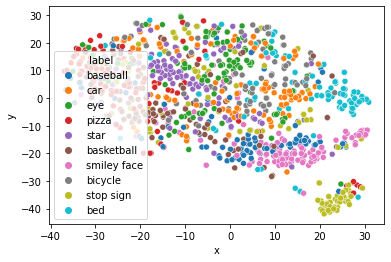

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

%matplotlib inline

# TODO: Implement the TSNE function to gather the transformed embeddings.
transformed = TSNE().fit_transform(embeddings[:1000, :])
label_names = list(const.DOODLE_TO_EMOJI_MAP.keys())

# This part is done for you! :)
df = pd.DataFrame([])
df['x'] = transformed[:, 0]
df['y'] = transformed[:, 1]
df['label'] = [label_names[i] for i in labels[0:1000]]
sns.scatterplot(data=df, x='x', y='y', hue='label')
plt.show()

Congratulations! If you've made it this far, please copy this plot and share it in the #projects-apr22 channel along with your submission.

Consider the plot: can you see distinct clusters corresponding to the different classes?

# Part 2: Generative models (Optional!)

Now that we've trained our own CNN classification model, let's do the reverse -- using convolutional layers, let's train (fine-tune) a model to generate images!

  This project will be based on a Colab implementation of a recent paper, [JoJoGAN](https://github.com/mchong6/JoJoGAN). The model takes as input an image of a face, and then, given some training examples, transforms this face into the style of the training examples. Below is an illustration of this model in action:

<img src="https://drive.google.com/uc?id=10JaUluszJEClQ1ZcyTGlKjErJaE57p2X" width="600">

This module shows off the power of transfer learning -- instead of training a model from scratch, we are starting with a pre-trained model that has seen thousands of faces and styles already. Using the model, we will simply fine-tune the model on our own small training dataset to get it to match the style in those images.

This module won't require you to code (phew!). Instead, you wil be executing cells to perform the necessary steps for training. We encourage you to double-click into each of the cells -- you will find that the code should look quite familiar in fact.

The general structure of this GAN goes as follows:

1. Take a photo using your webcam.
2. We use a face detector model (non-deep learning) to center your face and remove unnecessary background.
3. We load the generator CNN model.
4. Upload your training dataset and process them through the face detector model as well.
5. Train your model!
6. Using your trained model, generate your face-filtered examples!

**TODO**: Now would be a good time to clear your GPU of any leftover memory footprint from the previous module. Click on "Runtime" > "Disconnect and delete runtime" > "Restart runtime".

In [ ]:
#@title Import more packages! (This will take a few minutes.)
!pip install tqdm gdown lpips dlib opencv-python
!sudo unzip /content/drive/MyDrive/DLE-Projects/utils/week3/ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
sys.path.append(os.path.join(directory, 'utils', 'week3'))
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
from model import *
from e4e_projection import projection as e4e_projection
from util import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
Archive:  /content/drive/MyDrive/DLE-Projects/utils/week3/ninja-linux.zip
  inflating: /usr/local/bin/ninja    
update-alternatives: using /usr/local/bin/ninja to provide /usr/bin/ninja (ninja) in auto mode
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#@title 0. Run this cell to create your data folder "week3_data".
#@markdown You should be able to see this folder by selecting the folder icon on the left panel.
data_dir = '/content/week3_data/' #@param {type:"string"}
week3_dir = os.path.join(directory, 'utils/week3')
%cd $week3_dir
os.makedirs(data_dir, exist_ok=True)
if not os.path.exists(data_dir):
  display(md(f'Error creating the folder! Restart your runtime and try again.'))
else:
  display(md(f'### Created `{data_dir}` successfully!'))


/content/drive/.shortcut-targets-by-id/1QgsrP5HH39Mi5Bpja_MN9b-yRSVz-hRn/DLE-Projects/utils/week3


### Created `/content/week3_data/` successfully!

In [ ]:
#@title 1. Run this cell to take a photo!

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo(f'{data_dir}photo.jpg')
  print(f'Saved to {filename}')
  import time; time.sleep(3)
  # Show the image which was just taken.
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
#@title 2. Process and view aligned face
%matplotlib inline
filename = 'photo.jpg'
filepath = f'{data_dir}{filename}'
device = torch.device('cuda')

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

my_w = e4e_projection(aligned_face, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')

In [ ]:
#@title 3. Load the  generator model

latent_dim = 512 #256

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)


transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


In [ ]:
#@title 4. Process your own style training images.
#@markdown Now, upload your own training images! Pick at least 4 face images of a certain style and specify the filenames in the field below.

#@markdown To upload, simply drop the images into the `week3_data` folder under the folder tab on the left panel.

#@markdown We've provided you sample sketch images -- you can download these in the `deep-learning-essentials/utils/week3/week3_images` folder.

names = ['sketch.jpeg', 'sketch2.jpeg', 'sketch3.jpeg', 'sketch4.jpeg'] #@param
print("Image names:")
print(names)
targets = []
latents = []
style_images = []

for name in names:
    style_path = os.path.join(data_dir, name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = f'{name}_aligned.png'
    # if not os.path.exists(style_aligned_path):
    style_aligned = align_face(style_path)
    style_images.append(style_aligned)
    #     style_aligned.save(style_aligned_path)
    # else:
    #     style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    # style_code_path = os.path.join('inversion_codes', f'{name}.pt')
    # if not os.path.exists(style_code_path):
    latent = e4e_projection(style_aligned, device)
    # else:
    #     latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

target_im = utils.make_grid(targets, normalize=True, range=(-1, 1))
display_image(target_im, title='Style References')

In [ ]:
#@title Finetune model
#@markdown Finally, let's train our model on these images.

#@markdown `alpha` controls the strength of the style.  The larger this value, the more your face will conform to this style.
torch.cuda.empty_cache()

alpha =  0.5 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1-alpha

#@markdown Log training on wandb and interval for image logging
use_wandb = True #@param {type:"boolean"}
log_interval = 50 #@param {type:"number"}

#@markdown Number of finetuning steps. Different style reference may require different iterations. Try 200~500 iterations.
num_iter =  10#@param {type:"number"}

if use_wandb:
    wandb.init(project="JoJoGAN")
    config = wandb.config
    config.num_iter = num_iter
    wandb.log(
    {"Style reference": [wandb.Image(transforms.ToPILImage()(target_im))]},
    step=0)

# load discriminator for perceptual loss
discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)

    with torch.no_grad():
        real_feat = discriminator(targets)
    fake_feat = discriminator(img)

    loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)])/len(fake_feat)

    if use_wandb:
        wandb.log({"loss": loss}, step=idx)
        if idx % log_interval == 0:
            generator.eval()
            my_sample = generator(my_w, input_is_latent=True)
            generator.train()
            my_sample = transforms.ToPILImage()(utils.make_grid(my_sample, normalize=True, range=(-1, 1)))
            wandb.log(
            {"Current stylization": [wandb.Image(my_sample)]},
            step=idx)

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

In [ ]:
#@title Generate results
#@markdown The hard work is over! Run this cell to generate the results of your trained model.
#@markdown Try adjusting the input random seed to see how the outputs change.
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
# style_images = []
transformed_style_images = []
for image in style_images:
  transformed_style_images.append(transform(image))
# for name in names:
#     style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
#     style_image = transform(Image.open(style_path))
#     style_images.append(style_image)

face = transform(aligned_face).to(device).unsqueeze(0)
transformed_style_images = torch.stack(transformed_style_images, 0).to(device)
display_image(utils.make_grid(transformed_style_images, normalize=True, range=(-1, 1)), title='References')

my_output = torch.cat([face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')